# Generating Names With an RNN

Adapted from https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html. We are going to train on a list of names from 18 different languages. First, we will use an RNN to classify which language a name comes from. Then we will use the same RNN to generate new names.

## Classifying Languages

Since we have a lot of foreign letters in this data, we convert them to the 26-letter English alphabet for convenience. This code is taken from http://stackoverflow.com/a/518232/2809427.

In [6]:
import string, unicodedata

all_letters = string.ascii_letters + " .,;'"
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print('After string conversion, Ślusàrski becomes', unicodeToAscii('Ślusàrski'))

After string conversion, Ślusàrski becomes Slusarski


Now we read all the names from data files and group them by language.

In [7]:
import glob

all_languages = []
names = {}

for filename in glob.glob('Files/*.txt'):
    language = filename.split('/')[-1].split('.')[0]
    all_languages.append(language)
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    names[language] = [unicodeToAscii(line) for line in lines]

In [8]:
print(list(names.keys()))
for language in names.keys():
    print(language, names[language][:5])

['Vietnamese', 'Italian', 'Dutch', 'Arabic', 'Scottish', 'Polish', 'Portuguese', 'English', 'French', 'Chinese', 'Japanese', 'Irish', 'Spanish', 'Greek', 'German', 'Czech', 'Russian', 'Korean']
Vietnamese ['Nguyen', 'Tron', 'Le', 'Pham', 'Huynh']
Italian ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
Dutch ['Aalsburg', 'Aalst', 'Aarle', 'Achteren', 'Achthoven']
Arabic ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']
Scottish ['Smith', 'Brown', 'Wilson', 'Campbell', 'Stewart']
Polish ['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz']
Portuguese ['Abreu', 'Albuquerque', 'Almeida', 'Alves', 'Araujo']
English ['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']
French ['Abel', 'Abraham', 'Adam', 'Albert', 'Allard']
Chinese ['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']
Japanese ['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara']
Irish ['Adam', 'Ahearn', 'Aodh', 'Aodha', 'Aonghuis']
Spanish ['Abana', 'Abano', 'Abarca', 'Abaroa', 'Abascal']
Greek ['Adamidis', 'Adamou', 'Agelako

To feed the names into an RNN, we turn each letter in the name into a one-hot vector, and then convert the entire name into a 2D vector. Since we're working with PyTorch, we'll store the data in the Tensor format.

In [9]:
import torch

def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, len(all_letters))
    for i, letter in enumerate(name):
        tensor[i][0][all_letters.find(letter)] = 1
    return tensor

print(nameToTensor('Jones'))

tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,

Now we create the model.

In [10]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

hidden_size = 128
rnn = RNN(len(all_letters), hidden_size, len(all_languages))

As a test, we pass in the first letter of the name "Albert".

In [11]:
input = nameToTensor('Albert')
hidden = torch.zeros(1, 128)
output, next_hidden = rnn(input[0], hidden)

In [12]:
output

tensor([[-2.8325, -2.8060, -2.9658, -2.9608, -2.9377, -2.9093, -2.8434,
         -2.9225, -2.8478, -2.9315, -2.9717, -2.8517, -2.8966, -2.8649,
         -2.8273, -2.8816, -2.8661, -2.9323]])

The output is in the form of likelihoods for each language, so let's see what the top language is. Right now the net is not trained, so the result doesn't really mean anything.

In [14]:
def topLanguage(output):
    top_n, top_i = output.topk(1)
    top_i = top_i[0].item()
    return all_languages[top_i], top_i

print(topLanguage(output))

('German', 1)


Now let's train. We'll use user input as test data, so we can use the entire dataset as training data.

In [15]:
import torch.utils.data
import numpy as np
from sklearn.utils import shuffle

X_train = []
y_train = []
for language in names.keys():
    X_train += names[language]
    y_train += [all_languages.index(language)]*len(names[language])
X_train = [nameToTensor(name) for name in X_train]
X_train, y_train = shuffle(X_train, y_train)
y_train = torch.from_numpy(np.array(y_train)).type(torch.LongTensor)

In [134]:
learning_rate = 0.005
n_epochs = 10
plot_every = 1000
loss_function = nn.NLLLoss()

def train(language, name):
    hidden = torch.zeros(1, hidden_size)
    rnn.zero_grad()
    for i in range(name.size()[0]):
        output, hidden = rnn(name[i], hidden)
    loss = loss_function(output, language.view(1))
    loss.backward()
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.item()

current_loss = 0
all_losses = []
for i in range(n_epochs):
    for j, (name, language) in enumerate(zip(X_train, y_train)):
        output, loss = train(language, name)
        current_loss += loss
        # Add current loss avg to list of losses
        if (j+1) % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

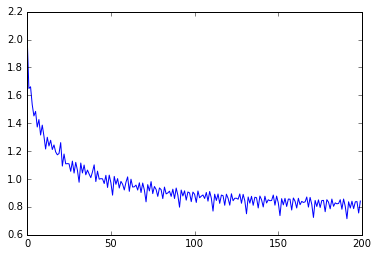

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

We will now create a plot called a confusion matrix, showing how often the model thinks names of one language come from a different language.

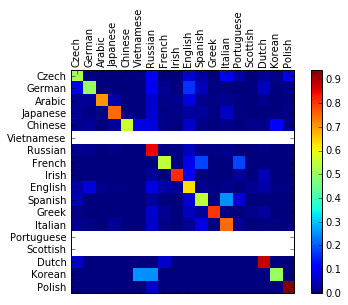

In [136]:
confusion = torch.zeros(len(all_languages), len(all_languages))

def evaluate(name):
    hidden = torch.zeros(1, hidden_size)
    for i in range(name.size()[0]):
        output, hidden = rnn(name[i], hidden)
    return output

for name, language in zip(X_train, y_train):
    output = evaluate(name)
    _, guess_i = topLanguage(output)
    confusion[guess_i][language.item()] += 1

# Normalize by dividing every row by its sum
for i in range(len(all_languages)):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels([''] + all_languages, rotation=90)
ax.set_yticklabels([''] + all_languages)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

Now we allow the user to test the model with new names.

In [137]:
def predict(name, n_predictions=3):
    print('\n> %s' % name)
    with torch.no_grad():
        output = evaluate(nameToTensor(name))
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            language_i = topi[0][i].item()
            print('(%.2f) %s' % (value, all_languages[language_i]))
            predictions.append([value, all_languages[language_i]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.04) Russian
(-4.01) Czech
(-4.26) English

> Jackson
(-0.57) English
(-0.96) Russian
(-4.49) Scottish

> Satoshi
(-0.51) Japanese
(-1.53) Arabic
(-3.07) Italian


## Generating Names

We use a slightly more complicated net, where the language is fed in at each step, and the output is the expected next letter. Here we allow one extra letter to represent end of word.

In [66]:
class RNN_gen(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(len(all_languages) + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(len(all_languages) + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, language, letter, hidden):
        input_combined = torch.cat((language, letter, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

hidden_size = 128
rnn_gen = RNN_gen(len(all_letters)+1, hidden_size, len(all_letters)+1)

Here, since we want to predict the next letter at every step, and not just the language at the very end, we have to update loss on every step.

In [78]:
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, len(all_letters)+1)
    for i in range(len(name)):
        letter = name[i]
        tensor[i][0][all_letters.find(letter)] = 1
    return tensor
def shiftedName(name):
    letter_indexes = [all_letters.find(name[i]) for i in range(1, len(name))]
    letter_indexes.append(len(all_letters)) # EOS
    return torch.LongTensor(letter_indexes)

In [79]:
X_train = []
y_train = []
for language in names.keys():
    X_train += names[language]
    y_train += [all_languages.index(language)]*len(names[language])
X_train, y_train = shuffle(X_train, y_train)
y_train = torch.from_numpy(np.array(y_train))

In [81]:
learning_rate = 0.0005
n_epochs = 10
plot_every = 1000
loss_function = nn.NLLLoss()

def train(language, name):
    hidden = torch.zeros(1, hidden_size)
    rnn_gen.zero_grad()
    language_one_hot = torch.zeros(1, len(all_languages))
    language_one_hot[0][language.item()] = 1
    loss = 0
    shifted_name = shiftedName(name)
    shifted_name.unsqueeze_(-1)
    name = nameToTensor(name)
    for i in range(name.size(0)):
        output, hidden = rnn_gen(language_one_hot, name[i], hidden)
        loss += loss_function(output, shifted_name[i])
    loss.backward()
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn_gen.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.item()

all_losses = []
for i in range(n_epochs):
    current_loss = 0
    for j, (name, language) in enumerate(zip(X_train, y_train)):
        output, loss = train(language, name)
        current_loss += loss
        # Add current loss avg to list of losses
        if (j+1) % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

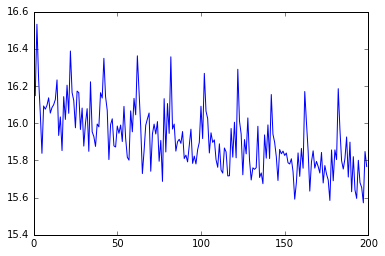

In [82]:
plt.plot(all_losses)

In [83]:
max_length = 20

def generate(language, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        language_one_hot = torch.zeros(1, len(all_languages))
        language_one_hot[0][all_languages.index(language)] = 1
        input_letter = nameToTensor(start_letter)[0]
        hidden = torch.zeros(1, hidden_size)
        output_name = start_letter
        for i in range(max_length):
            output, hidden = rnn_gen(language_one_hot, input_letter, hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == len(all_letters):
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = nameToTensor(letter)[0]
        print(output_name)

generate('Russian', 'R')
generate('German', 'G')
generate('Spanish', 'S')
generate('Chinese', 'C')

Raiiaiiieiyyyyyeeaeee
Grueerrrrrerrrrrrrrrl
Saaaaaaaaaaaeeaiaaaaa
Cha
